Specific heat : cv = 90.48524987488068 
error in cv: cv_error = 0.5245904324914277


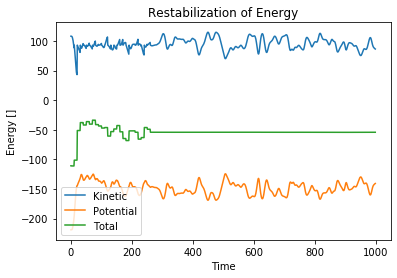

Text(0.5, 0.92, 'Trajectory of all particles in 3D')

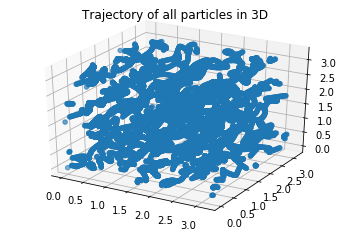

In [638]:
import numpy as np
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation
from scipy.optimize import curve_fit
import functions1 as fnc
import sys

sys.path.append("Project-1_N_mido1")

################################################################################################
################################# Initilazing the Simulation ###################################

# natural constanst
eps = 1 #119.8*1.38*10**-23
sigma = 1 #3.405E-10
mass = 1 #6.6E-26

# primitive unit cell of an FCC lattice
unitCell = np.array([[[0, 0, 0], [0.5, 0.5, 0],
                           [0.5, 0, 0.5], [0, 0.5, 0.5] ]])

multiplier = 2                          # amount of multiplication of the unitcell

D = unitCell.shape[2]                   # dimensions in accordence with the unit cell
N = multiplier**D*unitCell.shape[1]     # number of particles 
rho = 1
L = (N/rho)**(1/D)                      # Length of the box

dt = 3e-3*np.sqrt(mass*sigma**2/eps)    # timestep to look at
Timesteps = 1000                        # number of timesteps
T_initial = 2


# initilazing the coordinates and velocities
meanVelocity = 0                    
devVelocity = np.sqrt(T_initial)
v = np.random.normal(meanVelocity, devVelocity, (N,D))          # create intitial velocity from gauss distribution
r = np.zeros((N, D, Timesteps))                                 # create matrix to store positions                                
r[:,:,0] = fnc.createLattice(multiplier, unitCell, L)           # initilaze position
F = fnc.calculateForce(r[:,:,0],L)                              

# initilazing the Energies
kineticE = np.zeros(Timesteps)
potentialE = np.zeros(Timesteps)
kineticE[0] = fnc.kineticEnergy(v)
potentialE[0] = fnc.potentialEnergy(r[:,:,0],L)

# Restabilization of the energy
checkTime = np.arange(0,Timesteps, 10)      # create times to check for the Temperature every 10 steps
Temperature = np.zeros(Timesteps)
Temperature[0] = kineticE[0]/((N-1)*3/2)    # initilaze the Temperature with equipartion
reachedTemperature = False                  # set a boolean for the disired Temperature



################################################################################################
################################# Running the Simulation ###################################

for i in range(1,Timesteps):
    
    # calculate the energies and Temperature at each timestep
    kineticE[i] = fnc.kineticEnergy(v)
    potentialE[i] = fnc.potentialEnergy(r[:,:,i-1],L)
    Temperature[i] = kineticE[i]/((N-1)*3/2)

    # verlet algorithm
    r[:,:,i] = r[:,:,i-1] + dt*v + 0.5*fnc.calculateForce(r[:,:,i-1],L)*dt**2
    r[:,:,i] = r[:,:,i]%L

    # at some times check if the desired Temperature has been reached, if not multiply the 
    # velocities with lambda
    if i in checkTime and not reachedTemperature:
        if np.abs(((T_initial- Temperature[i]))/T_initial) < 0.01:
            reachedTemperature = True
            v = v + 0.5*dt*(fnc.calculateForce(r[:,:,i],L)+ fnc.calculateForce(r[:,:,i-1],L))
        else:
            v = np.sqrt(((N-1)*3/2*T_initial)/kineticE[i])*v
    else:
        v = v + 0.5*dt*(fnc.calculateForce(r[:,:,i],L)+ fnc.calculateForce(r[:,:,i-1],L))



# Calculating Specific Heat
average = 1/Timesteps*np.sum(kineticE)
var = (1/Timesteps)*np.sum(kineticE**2) - average**2
A = var/(average**2)

cv = (2/(3*N) -A)**(-1)
print(f"Specific heat : cv = {cv} ")

# Calculating the error of the observable Specific Heat
N_error = 100
N_subset = 100000
Cv = np.zeros(N_error)

for i in range(N_error):
    kineticE_subset = np.random.choice(kineticE,N_subset)

    average = 1/N_subset*np.sum(kineticE_subset)
    var = (1/N_subset)*np.sum(kineticE_subset**2) - average**2
    A = var/(average**2)

    Cv[i] = (2/(3*N) -A)**(-1)

average_cv = 1/N_error*np.sum(Cv)
error_cv = np.sqrt((1/N_error)*np.sum(Cv**2) - average_cv**2)

print(f"error in cv: cv_error = {error_cv}" )





################################################################################################
################################# Plots #########################################################
#plt.figure(2)
#plt.plot(r[0,0,:], r[0,1,:], 'ro')
#plt.plot(r[2,0,:], r[2,1,:], 'bo')
#plt.title("Trajectory of 2 particles")



plt.figure(1)
plt.plot(np.arange(Timesteps), kineticE, label = "Kinetic" )
plt.plot(np.arange(Timesteps), potentialE, label = "Potential")
plt.plot(np.arange(Timesteps), potentialE + kineticE, label =  "Total")

plt.ylabel("Energy []")
plt.xlabel("Time")
plt.title("Restabilization of Energy")
plt.legend()
#plt.savefig("Restabilization.png")
plt.show(1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(r[:,0,:], r[:,1,:], r[:,2,:], zdir='z')
plt.title("Trajectory of all particles in 3D")
#plt.savefig('Trajectory_of_all_particles in 3D.png')

#plt.show()


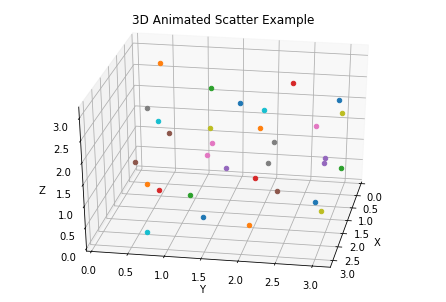

In [549]:
def animate_scatters(iteration, data, scatters):
    """
    Update the data held by the scatter plot and therefore animates it.
    Args:
        iteration (int): Current iteration of the animation
        data (list): List of the data positions at each iteration.
        scatters (list): List of all the scatters (One per element)
    Returns:
        list: List of scatters (One per element) with new coordinates
    """
    for i in range(data[0].shape[0]):
        scatters[i]._offsets3d = (data[iteration][i,0:1], data[iteration][i,1:2], data[iteration][i,2:])
    return scatters

def main(data, save=True):
    """
    Creates the 3D figure and animates it with the input data.
    Args:
        data (list): List of the data positions at each iteration.
        save (bool): Whether to save the recording of the animation. (Default to False).
    """

    # Attaching 3D axis to the figure
    fig = plt.figure()
    ax = p3.Axes3D(fig)

    # Initialize scatters
    scatters = [ ax.scatter(data[0][i,0:1], data[0][i,1:2], data[0][i,2:]) for i in range(data[0].shape[0]) ]

    # Number of iterations
    iterations = Timesteps

    # Setting the axes properties
    ax.set_xlim3d([0, L])
    ax.set_xlabel('X')

    ax.set_ylim3d([0, L])
    ax.set_ylabel('Y')

    ax.set_zlim3d([0, L])
    ax.set_zlabel('Z')

    ax.set_title('3D Animated Scatter Example')

    # Provide starting angle for the view.
    ax.view_init(30, 10)

    ani = animation.FuncAnimation(fig, animate_scatters, iterations, fargs=(data, scatters),
                                       interval=50, blit=True, repeat=True)

    if save:
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800, extra_args=['-vcodec', 'libx264'])
        ani.save('3d-Movement_argon_atoms.mp4', writer=writer)

    plt.show()
data = np.transpose(r, (2,0,1))   
main(data, save=True)

In [316]:
dev = 0.5
mean = 0
D = 3
N = 5
def velocityGauss(N, D, dev, mean):
    return np.random.normal(mean, dev, (N,D))

print(velocityGauss(N,D, dev, mean))


[[-0.16802954 -0.04303696  0.85137941]
 [ 0.17628215 -0.02269437 -0.76581541]
 [ 0.31767042  0.50342727  1.32405183]
 [-0.36438074  0.47293516 -0.37163148]
 [-0.24090068  0.91636578  1.22104801]]
